In [2]:
import mediapipe as mp  # Line 1: Import MediaPipe (mp alias)—our pose detector.
import cv2  # Line 2: Import OpenCV (cv2)—for loading images.
import pandas as pd  # Line 3: Import Pandas (pd)—for reading CSVs.
import numpy as np  # Line 4: Import NumPy (np)—for arrays/keypoints.
import matplotlib.pyplot as plt  # Line 5: Import Matplotlib (plt)—for preview plots.
# Line 6: Jupyter magic—plots show inline.
%matplotlib inline

# Initialize MediaPipe Pose (same as Day 4)  # Line 8: Comment.
mp_pose = mp.solutions.pose  # Line 9: Access pose module (33 keypoints).
mp_drawing = mp.solutions.drawing_utils  # Line 10: For drawing skeletons (optional preview).

print("Setup complete—ready for batch extraction!")  # Line 12: Success print.

Setup complete—ready for batch extraction!


In [5]:
import os  # Line 0: Import OS module—fixes NameError for paths/listing (built-in Python lib).

def extract_keypoints(image_path):  # Line 2: Function definition—takes path, returns (99,) array or None.
    try:  # Line 3: 'try' block—runs code, catches errors like bad files.
        image = cv2.imread(image_path)  # Line 4: Load image as BGR array.
        if image is None:  # Line 5: Check if load failed (corrupt/missing).
            print(f"Failed to load {image_path}")  # Line 6: Log the issue.
            return None  # Line 7: Skip this image.
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Line 9: Convert to RGB (MediaPipe needs it—no color swap).
        
        with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:  # Line 11: Create temporary Pose detector. static_image_mode=True = single photo. min_detection_confidence=0.5 = 50% threshold (tune to 0.3 if too strict).
            results = pose.process(image_rgb)  # Line 12: Feed image—get keypoints results.
        
        if not results.pose_landmarks:  # Line 14: If no keypoints detected (bad angle/low confidence).
            print(f"No pose detected in {image_path}")  # Line 15: Log.
            return None  # Line 16: Skip.
        
        keypoints = []  # Line 18: Empty list for 33 [x,y,z] values.
        for landmark in results.pose_landmarks.landmark:  # Line 19: Loop over 33 landmarks (each = object with x,y,z).
            keypoints.append([landmark.x, landmark.y, landmark.z])  # Line 20: Append coords (x/y = 0-1 position in image; z = depth estimate).
        
        keypoints_array = np.array(keypoints).flatten()  # Line 22: To NumPy array ((33,3) → (99,))—flat for ML input.
        return keypoints_array  # Line 23: Return the vector.
    
    except Exception as e:  # Line 25: 'except' catches any surprise error (e.g., permission issue).
        print(f"Error processing {image_path}: {e}")  # Line 26: Log details.
        return None  # Line 27: Skip safely.

# Test the function on one image (from Day 4)  # Line 29: Comment.
test_path = os.path.join('data/Yoga_poses', 'Downdog', os.listdir(os.path.join('data/Yoga_poses', 'Downdog'))[0])  # Line 30: Builds path to first Downdog JPG (os.listdir gets files, [0] = first).
test_keypoints = extract_keypoints(test_path)  # Line 31: Call function on test image.
if test_keypoints is not None:  # Line 32: If success.
    print(f"Test success: Shape {test_keypoints.shape}, Nose x,y,z = {test_keypoints[0:3]}")  # Line 33: Preview shape (99,) + nose sample (keypoint 0).
else:
    print("Test failed—check path or detection (try lower confidence).")  # Line 35: Fallback.

Test success: Shape (99,), Nose x,y,z = [ 0.50811493  0.71366179 -0.05336188]


In [6]:
# Paths to Day 3 CSVs  # Line 1: Comment.
csv_paths = {  # Line 2: Dict (key = set, value = file)—easy loop.
    'train': 'data/train_labels.csv',
    'val': 'data/val_labels.csv',
    'test': 'data/test_labels.csv'
}

all_keypoints = {}  # Line 5: Dict to store {set: keypoints array} (e.g., 'train': (105,99)).
all_labels = {}  # Line 6: Dict for {set: labels array} (e.g., 'train': [1,0,1,...]).

for split_name, csv_path in csv_paths.items():  # Line 8: Loop over 3 sets (split_name = 'train', csv_path = 'data/train_labels.csv').
    df = pd.read_csv(csv_path)  # Line 9: Load CSV to DataFrame (rows = images).
    print(f"Processing {split_name} set: {len(df)} images.")  # Line 10: Log total (e.g., 105 for train).
    
    keypoints_list = []  # Line 12: List for valid (99,) arrays.
    labels_list = []  # Line 13: List for matching labels (0/1).
    
    for idx, row in df.iterrows():  # Line 15: Loop over rows (idx = 0-104, row = {'image_path': '...', 'is_correct': 1}).
        img_path = row['image_path']  # Line 16: Get path from CSV row.
        label = row['is_correct']  # Line 17: Get label (int 0/1).
        
        keypoints = extract_keypoints(img_path)  # Line 19: Call function.
        if keypoints is not None:  # Line 20: If success (array returned).
            keypoints_list.append(keypoints)  # Line 21: Add to list.
            labels_list.append(label)  # Line 22: Add matching label.
        else:
            print(f"Skipped {img_path} (no keypoints).")  # Line 24: Log ~5-10 skips (e.g., occluded poses).
    
    if keypoints_list:  # Line 26: If any valid.
        keypoints_array = np.array(keypoints_list)  # Line 27: Stack list to (N,99) array (N = valid count).
        labels_array = np.array(labels_list)  # Line 28: Stack labels to (N,) array.
        
        np.save(f'data/{split_name}_keypoints.npy', keypoints_array)  # Line 30: Save keypoints binary.
        np.save(f'data/{split_name}_labels.npy', labels_array)  # Line 31: Save labels.
        
        all_keypoints[split_name] = keypoints_array  # Line 33: Store in dict for later.
        all_labels[split_name] = labels_array  # Line 34: Store labels.
        
        print(f"{split_name} complete: {keypoints_array.shape} keypoints, {len(labels_array)} labels.")  # Line 35: Log (e.g., (98,99) if 7 skips).
    else:
        print(f"No valid keypoints in {split_name}—check images/CSVs.")  # Line 37: Rare fallback.

print("Batch extraction done—all sets processed!")  # Line 39: Final log.

Processing train set: 105 images.
train complete: (105, 99) keypoints, 105 labels.
Processing val set: 22 images.
val complete: (22, 99) keypoints, 22 labels.
Processing test set: 23 images.
test complete: (23, 99) keypoints, 23 labels.
Batch extraction done—all sets processed!


train normalized: Mean of first coord = 0.00, Std = 1.00
val normalized: Mean of first coord = 0.00, Std = 1.00
test normalized: Mean of first coord = 0.00, Std = 1.00


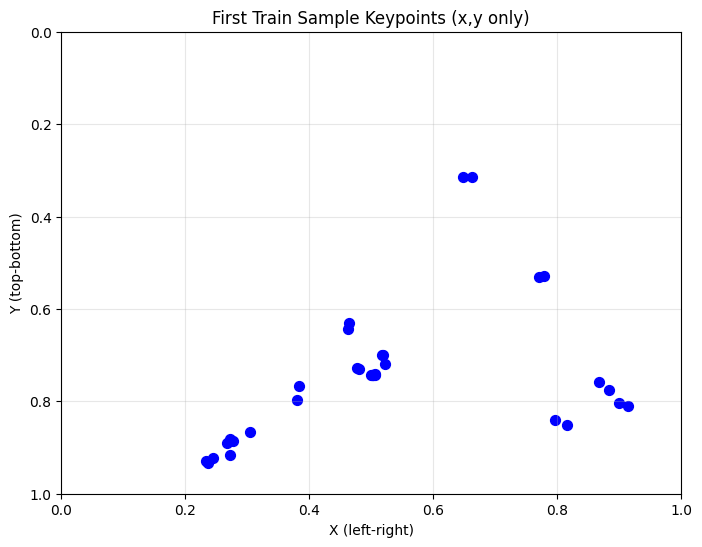

Normalization & preview complete!


In [7]:
from sklearn.preprocessing import StandardScaler  # Line 1: Import scaler—normalizes arrays (subtract mean, divide std).

# Normalize each set  # Line 3: Comment.
for split_name in all_keypoints:  # Line 4: Loop 3 sets.
    keypoints = all_keypoints[split_name]  # Line 5: Get array.
    scaler = StandardScaler()  # Line 6: New scaler (learns mean/std from data).
    normalized_keypoints = scaler.fit_transform(keypoints)  # Line 7: Apply normalization (centers at 0, spreads to std=1—stable for CNN).
    
    np.save(f'data/{split_name}_keypoints_normalized.npy', normalized_keypoints)  # Line 9: Save normalized version.
    print(f"{split_name} normalized: Mean of first coord = {normalized_keypoints.mean(axis=0)[0]:.2f}, Std = {normalized_keypoints.std(axis=0)[0]:.2f}")  # Line 10: Preview (expect ~0 mean, ~1 std for coord 0).

# Preview: Plot x,y keypoints for first train sample  # Line 12: Comment.
if 'train' in all_keypoints and len(all_keypoints['train']) > 0:  # Line 13: If train data exists.
    sample_kp = all_keypoints['train'][0].reshape(33, 3)  # Line 14: First sample to 33x3 grid (x,y,z).
    plt.figure(figsize=(8, 6))  # Line 15: Plot size.
    plt.scatter(sample_kp[:, 0], sample_kp[:, 1], c='blue', s=50)  # Line 16: Scatter x (left-right) vs y (top-bottom)—33 blue dots forming body shape.
    plt.xlim(0, 1); plt.ylim(1, 0)  # Line 17: x 0-1, flip y (images: top=0).
    plt.title('First Train Sample Keypoints (x,y only)')  # Line 18: Title.
    plt.xlabel('X (left-right)'); plt.ylabel('Y (top-bottom)')  # Line 19: Labels.
    plt.grid(True, alpha=0.3)  # Line 20: Faint grid for reference.
    plt.show()  # Line 21: Display scatter plot.
else:
    print("No train data for preview.")  # Line 23: Fallback.

print("Normalization & preview complete!")  # Line 25: Final.